In [1]:
# confidence interval and w-estimator simulations for non-stationary time series examples
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import probscale 
%matplotlib inline
import seaborn as sns
sns.set(style='white', palette='colorblind', color_codes=True)
import scipy.linalg as la
import scipy.stats as spstats
import pylab 



In [64]:
# set  seed
seed = 1234
np.random.seed(seed)

# parameters: T: length of time series; p = memory of AR process; R = number of Monte Carlo trials;

R = 4000
T = 100
p = 1

# Data generating process: 
# y_{t} = beta_{p-1} y_{t-1} + beta_{p-2} y_{t-2} + ... + beta_{0} y{t-p} + eps_{t}

# betaTrue initialization:
# betaTrue_a ~ Beta(0.1, 0.1) i.i.d, 
# if betaTrue_0 is set to 0.95 (0.2) if nonstationary (stationary) experiment is run
# set experiment flag stationary if desired simulation is stationary experiment 
betaTrue = np.random.beta(0.2, 0.2, size=p) # 
stationary = False
if not stationary : betaTrue[0] = 1.0
elif stationary : betaTrue[0] = 0.2
    
# time series variable y
y = np.zeros(T)
y_full = np.zeros((T, R))

# nominal confidence levels
coverageProbs = np.arange(0.01, 0.12, step=0.02)
# precomputing threshold multipliers for Gaussian and Concentration inequality tails
gaussianThresholds = np.abs(spstats.norm.ppf(coverageProbs))
concThresholds = (np.sqrt(max(p, 2)*(np.log(T**3) + np.log(1/coverageProbs))))

In [ ]:
# generate time series data for every monte carlo simulations
for mc in range(R):
    # create noise variables
    eps = 2*np.random.rand(T)-1.0
    v = np.zeros(T)
    for timeStep in range(p, T):
        v[timeStep] = np.dot(v[timeStep-p: timeStep], betaTrue) + eps[timeStep]
    y_full[:, mc] = v
data_pairs = []

for mc in range(R):
    X = np.zeros((T-p, p))
    y = np.zeros(T-p)
    for timeStep in range(p, T):
        y[timeStep-p] = y_full[timeStep, mc]
        X[timeStep-p, :] = y_full[timeStep-p:timeStep, mc]
    data_pair={'y':y, 'X':X}
    data_pairs.append(data_pair)

In [66]:
# define coarse experiment paramters to be computed on data pairs
params = {}
param_methods = {}
def lambda_min(data_pair):
    lambdas = la.eigvalsh(np.dot( data_pair['X'].T, data_pair['X']))
    return lambdas[0]
param_methods['lambda_min'] = lambda_min

def fisher_inf(data_pair):
    lambdas = la.eigvalsh(np.dot( data_pair['X'].T, data_pair['X']))
    return sum(1/lambdas)
param_methods['fisher_inf'] = fisher_inf

for param_name in param_methods.keys():
    params[param_name] = np.zeros(R)


In [67]:
# now compute estimates with each method, starting with OLS

estimates = {}
estimate_methods = ['OLS_gsn', 'W', 'OLS_conc']
variances = {}


for estimate_method in estimate_methods:
    estimates[estimate_method] = np.zeros((p, R))
    variances[estimate_method] = np.zeros((p, R))
    
# compute OLS estimates, needed experiment parameters for W estimates    
for mc in range(R):
    y = data_pairs[mc]['y']
    X = data_pairs[mc]['X']
    beta_ols, _, _, _ = la.lstsq(X, y)
    varianceEstimated = np.mean((y - X.dot(beta_ols))**2)
    eigv, eigvec = la.eigh(np.dot(X.T, X))
    
    estimates['OLS_gsn'][:, mc] = beta_ols
    estimates['OLS_conc'][:, mc] = beta_ols
    
    variances['OLS_gsn'][:, mc] = np.diag(eigvec.dot(np.diag(1/eigv)).dot(eigvec.T))*varianceEstimated
    variances['OLS_conc'][:, mc] = np.diag(eigvec.dot(np.diag(1/eigv)).dot(eigvec.T))
    
    # compute other parameters needed for W estimates, e.g. lower bounds on inverse Fisher information. 
    for param_name in param_methods.keys():
        params[param_name][mc] = param_methods[param_name](data_pairs[mc])
    
# compute W estimates

for mc in range(R):
    
    y = data_pairs[mc]['y']
    X = data_pairs[mc]['X']
    n = len(y) # should be T-p
    
    # set regularization parameter for frobenius W
    lam_frob = np.percentile(params['lambda_min'], 5)/np.log(n)
    
    W_frob = np.zeros((p, n))
    resid_mat = np.eye(p)
    for i in range(n):
        W_frob[:, i] = resid_mat.dot(X[i, :])/(lam_frob + la.norm(X[i, :])**2)
        resid_mat = resid_mat - np.outer(W_frob[:, i], X[i, :])
    estimates['W'][:, mc] = beta_ols + W_frob.dot(y - X.dot(beta_ols))
    variances['W'][:, mc] = np.diag(W_frob.dot(W_frob.T))*varianceEstimated
    
#     # set spectral parameters
#     lam_sp = lam_frob
#     W_sp = np.zeros((p, n))
#     resid_mat = np.eye(p)
#     for i in range(n):
#         pass
#     estimates['W_sp'][:, mc] = beta_ols + W_sp.dot(y -X.dot(beta_ols))
#     variances['W_sp'][:, mc] = np.diag(W_sp.dot(W_sp.T))
    
    

In [68]:
# now compute statistics for all methods

# initialize containers for performance statistics
stats = {}
statTypes = ['upperTail', 'lowerTail', 'width', 'normErr']
for stat in statTypes :   
    stats[stat] = {}
    for estimate_method in estimate_methods:
        stats[stat][estimate_method] = np.zeros((p, len(coverageProbs), R))

# compute performance stats for each MC iteration        
for mc in range(R):
    threshold = {}
    threshold['OLS_gsn'] = np.outer(np.sqrt(variances['OLS_gsn'][:, mc]), gaussianThresholds)
    threshold['OLS_conc'] = np.outer(np.sqrt(variances['OLS_conc'][:, mc]), concThresholds)
    threshold['W'] = np.outer(np.sqrt(variances['W'][:, mc]), gaussianThresholds)
    for method in estimate_methods:
        stats['upperTail'][method][:, :, mc] = np.double(np.outer(estimates[method][:, mc]-betaTrue, np.ones(len(coverageProbs))) > threshold[method])
        stats['lowerTail'][method][:, :, mc] = np.double(np.outer(estimates[method][:, mc] - betaTrue, np.ones(len(coverageProbs))) < -threshold[method])
        stats['width'][method][:, :, mc] = threshold[method]
        stats['normErr'][method][:, 0, mc] = (estimates[method][:, mc]-betaTrue)/np.sqrt(variances[method][:, mc])

# finally compute empirical (oracle) widths

stats['width']['OLS_emp'] = np.maximum(np.abs(np.percentile(estimates['OLS_gsn'] - np.outer(betaTrue, np.ones(R)), coverageProbs*100, axis=1)), \
                             np.abs(np.percentile(estimates['OLS_gsn']-np.outer(betaTrue, np.ones(R)), 100-coverageProbs*100, axis=1)))
stats['width']['OLS_emp'] = stats['width']['OLS_emp'].T

    

In [69]:
# set colors for methods and plots

colors = {}
colors['OLS_gsn'] = sns.color_palette()[0]
colors['OLS_conc'] = sns.color_palette()[2]
colors['W'] = sns.color_palette()[1]
colors['Nominal'] = (0, 0, 0)#sns.color_palette()[9]
colors['OLS_emp'] = sns.color_palette()[7]

markers = {}
markers['OLS_gsn'] = 'v'
markers['W'] = 'o'
markers['OLS_conc'] = '^'

label_font_size = 14
legend_font_size = 13
title_font_size = 14

path = 'figs/'

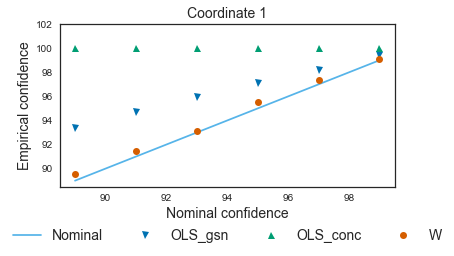

In [360]:
plotType = 'Empirical_Coverage_Probabilities_Upper_Tail'
statType = 'upperTail'
fig, axarr = plt.subplots(1, p, sharey = True, figsize = (5*p, 4))

for coord in range(p):
    if p ==1 : ax = axarr
for coord in range(p):
    if p ==1 : ax = axarr
    else : ax = axarr[coord]
    for method in ['OLS_gsn', 'OLS_conc', 'W']:
        ax.errorbar(100-100*coverageProbs, \
                    100*(1- np.mean(stats[statType][method][coord, :, :], axis=1)), \
                    # yerr = np.std(stats['upperTail'][method][coord, :, :], axis=1), \
                    label = method, marker = markers[method], color = colors[method], linestyle='')
    ax.plot(100 - 100*coverageProbs, 100*(1-coverageProbs), color = colors['Nominal'], label='Nominal')
    ax.set_ylim(top=101)
    ax.set_xlabel('Nominal confidence', fontsize = label_font_size)
    ax.set_ylabel('Empirical confidence', fontsize = label_font_size)
    ax.set_title('Coordinate {}'.format(coord+1), fontsize=title_font_size)
#fig.tight_layout()
#fig.suptitle(experimentType+plotType)

#ax.legend(bbox_to_anchor=(0., -0.3), loc='center left', borderaxespad=0., ncol=4, fontsize=legend_font_size)
ax.legend(('Nominal', 'OLS_gsn', 'OLS_conc', 'W'),
           loc='lower right', 
           bbox_to_anchor = (1, 0),  
           ncol=1, 
           fontsize=legend_font_size)

fig.savefig(path+experimentType+plotType, bbox_inches='tight', pad_inches=0.03)
plt.show()

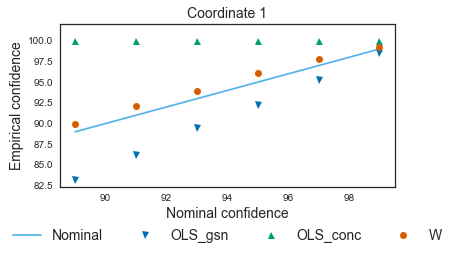

In [359]:
plotType = 'Empirical_Coverage_Probabilities_Lower_Tail'
statType = 'lowerTail'
fig, axarr = plt.subplots(1, p, sharey = True, figsize=(5*p, 4))

for coord in range(p):
    if p ==1 : ax = axarr
    else : ax = axarr[coord]
    for method in ['OLS_gsn', 'OLS_conc', 'W']:
        ax.errorbar(100-100*coverageProbs, \
                    100*(1- np.mean(stats[statType][method][coord, :, :], axis=1)), \
                    # yerr = np.std(stats['upperTail'][method][coord, :, :], axis=1), \
                    label = method, marker = markers[method], color = colors[method], linestyle='')
    ax.plot(100 - 100*coverageProbs, 100*(1-coverageProbs), color = colors['Nominal'], label='Nominal')
    ax.set_ylim(top=102)
    ax.set_xlabel('Nominal confidence', fontsize=label_font_size)
    ax.set_ylabel('Empirical confidence', fontsize=label_font_size)
    ax.set_title('Coordinate {}'.format(coord+1), fontsize=title_font_size)

# ax.legend(bbox_to_anchor=(-0.1, -0.3), loc='center', borderaxespad=0., ncol=4, fontsize=legend_font_size)
#ax.legend(bbox_to_anchor=(0., -0.3), loc='center', borderaxespad=0., ncol=4, fontsize=legend_font_size)
ax.legend(('Nominal', 'OLS_gsn', 'OLS_conc', 'W'),
           loc='lower right', 
           bbox_to_anchor = (1, 0),  
           ncol=1, 
           fontsize=legend_font_size)
#fig.tight_layout()
#fig.suptitle(experimentType+plotType)
fig.savefig(path+experimentType+plotType, bbox_inches='tight')
plt.show()


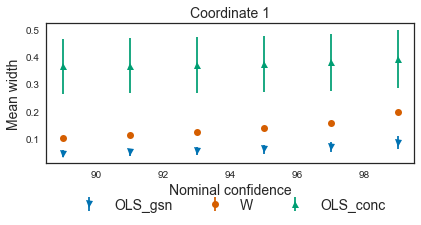

In [363]:
plotType = 'Width_Comparison'
statType = 'width'
fig, axarr = plt.subplots(1, p, sharey = True, figsize=(5*p, 4))

for coord in range(p):
    if p == 1: ax = axarr
    else: ax = axarr[coord]
    for method in ['OLS_gsn', 'W', 'OLS_conc']:
        ax.errorbar(100-100*coverageProbs, \
                    np.mean(stats[statType][method][coord, :, :], axis=1), \
                    np.std(stats[statType][method][coord, :, :], axis=1),\
                    label = method, color=colors[method], marker = markers[method], linestyle='')
    
    # ax.plot(100-100*coverageProbs, stats[statType]['OLS_emp'][coord, :], color = colors['OLS_emp'], label = 'OLS_emp')
    # ax.legend(loc='best', fontsize = legend_font_size)
    ax.set_xlabel('Nominal confidence', fontsize=label_font_size)
    ax.set_ylabel('Mean width', fontsize=label_font_size)
    ax.set_title('Coordinate {}'.format(coord+1), fontsize=title_font_size)

ax.legend(('OLS_gsn', 'W',  'OLS_conc'),
           loc='upper left', 
           bbox_to_anchor = (0, 1),  
           ncol=1, 
           fontsize=legend_font_size)#fig.tight_layout(pad=1)
fig.savefig(path+experimentType+plotType, bbox_inches='tight')
plt.show()

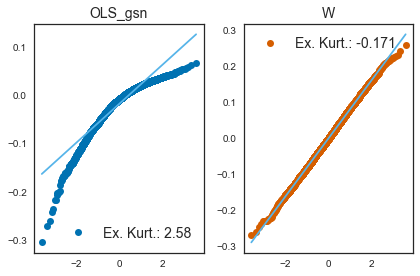

In [365]:
plotType = 'QQ_Plot'
statType = ''
fig, axarr = plt.subplots(p, 2, figsize = (10, 4*p))#sharey = True)
for coord in range(p):
    if p == 1: ax = axarr
    else: ax = axarr[coord]
    for k, method in enumerate(['OLS_gsn', 'W']):
        orderedstats, fitparams = spstats.probplot(stats['normErr'][method][coord, 0, :], 
                                                   dist="norm", 
                                                   sparams=(0, ), 
                                                   plot=None)
        ax[k].plot(orderedstats[0], 
                   orderedstats[1], 
                   marker='o',
                   markersize=4,
                   color = colors[method], 
                   linestyle='')
        ax[k].plot(orderedstats[0], 
                   fitparams[0]*orderedstats[0] + fitparams[1], 
                   color = colors['Nominal'], 
                   linewidth=1.5)
        print fitparams[1]
        #ax[k].plot(orderedstats[0], fitparams[0]*orderedstats[0] + fitparams[1])
        
        ax[k].legend(loc='upper left', 
                             labels=['Ex. Kurt.: {0:.3g}'.format(
                                spstats.kurtosis(stats['normErr'][method][coord, 0, :])*np.sqrt(R/24.0) )],
                     fontsize = legend_font_size)
        if coord == 0:
            ax[k].set_title(method, fontsize=title_font_size)        

 
fig.tight_layout()
fig.savefig(path+experimentType+plotType, bbox_inches='tight')
plt.show()

In [ ]:
plotType = 'PP_Plot'
statType = 'Normalized Error'
probvals = np.linspace(0, 1.0, 101)
bins = spstats.norm.ppf(probvals)
normdata = np.random.randn(R)
# data_counts, bins = np.histogram(data,bins)
# norm_counts, bins = np.histogram(norm,bins)
# cum_data = np.cumsum(data_counts)
# cum_norm = np.cumsum(norm_counts)

fig, axarr = plt.subplots(p, 2, figsize = (10, 4*p))#sharey = True)
for coord in range(p):
    if p == 1: ax = axarr
    else: ax = axarr[coord, :]
    for k, method in enumerate(['OLS_gsn', 'W']):
        data = stats['normErr'][method][coord, 0, :]
        datacounts, bins = np.histogram(data, bins, density=True)
        normcounts, bins = np.histogram(normdata, bins, density=True)
        cumdata = np.cumsum(datacounts)
        cumdata = cumdata/max(cumdata)
        cumnorm = np.cumsum(normcounts)
        cumnorm= cumnorm/max(cumnorm)
        ax[k].plot(cumnorm, cumdata, 
                   marker='o', 
                   color = colors[method], 
                   linestyle='', 
                   markersize=2.5
        )
#         ax[k].legend(loc='upper left', 
#                      labels=['Skewness: {0:.3g}'.format(
#                                 spstats.skew(data)/np.sqrt(6)*np.sqrt(R) )],
#                      fontsize = legend_font_size)
        if coord == 0:
            ax[k].set_title(method, fontsize=title_font_size)            
        ax[k].plot(probvals, probvals,
                  color=colors['Nominal'])
 
fig.tight_layout()
fig.savefig(path+experimentType+plotType, bbox_inches='tight')
plt.show()